In [2]:
#!cp ../rmcclure/procedure.py .

In [3]:
import numpy as np 
import pickle
from superfreq import SuperFreq
from matplotlib import pyplot as plt
from galpy.util import bovy_coords as coords
import gala.dynamics as gd
import astropy.units as u
import gala.coordinates as gc
import os
import sys
from procedure import *
import pandas as pd

In [4]:
!pwd

/mnt/home/bbhattarai


In [5]:
times=np.genfromtxt(path+'times.txt',dtype='str')
print("Total snapshots present is",len(times))
snapshot_start=0
snapshot_end=len(times)

Total snapshots present is 1188


In [6]:
!hostname

pcn-9-38


In [7]:
plotpath="/mnt/home/bbhattarai/resonance_sweeping/New_Sims_Analysis/plots/"

In [8]:
snapshot=1000
snaparr = loadwholesnap(path,snapshot)
print("These are the data we have",snaparr[0].dtype)
idd=snaparr['idd']
x=snaparr['x']
y=snaparr['y']
z=snaparr['z']
vx=snaparr['vx']
vy=snaparr['vy']
vz=snaparr['vz']  
mass=snaparr['mass']  #mass is in solar mass (change old mass calculations to take account of the factor 2.324876e9)

vr=snaparr['vr']
vphi=snaparr['vphi']
vzz=snaparr['vzz']
r=snaparr['r']
phi=snaparr['phi'] #phi is in radians
zz=snaparr['zz']

#converting phi to degrees
phi_degrees=np.rad2deg(phi)

These are the data we have [('t', '<f8'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('vr', '<f4'), ('vphi', '<f4'), ('vzz', '<f4'), ('r', '<f4'), ('phi', '<f4'), ('zz', '<f4'), ('mass', '<f4'), ('idd', '<u8')]


# Selecting the solar neighborhood

In [9]:
keep_sn=(x<8.2)*(x>7.8)*(y<0.5)*(y>-0.5)*(z<0.5)*(z>-0.5)

In [9]:
np.sum(keep_sn)

69260

In [10]:
freq_path="/mnt/home/bbhattarai/resonance_sweeping/New_Sims_Analysis/freq_data/"

column=["t", "omega_r","omega_phi","omega_z"] #column to store the data

idd_keep=idd[keep_sn] #narrowing the particle ids to solar neighborhood only
ndim=6 # dimension of phase space
keep_small=idd_keep[1000:1001] #selecting a group of 15 particles for test, change it 

for i in range(len(keep_small)):
    
    test_particle=keep_small[i]  #test paticle to look at
    df = pd.DataFrame(columns=column)
    for j in range(0,1040,40):
        #print("looking orbits of particle:",i)
        
        test = loadonesource(path,test_particle,start=j,finish=j+40) # do it for 200 Myr
        
        #calculate frequencies every 200 Myrs (0-200, 200-400, 400-600, 600-800 in time (Myrs)) (0-40. 40-80..... in snapshots)
        x_test=test['r'].astype(np.float64)
        y_test=test['phi'].astype(np.float64)
        z_test=test['zz'].astype(np.float64)
        vx_test=test['vr'].astype(np.float64)
        vy_test=test['vphi'].astype(np.float64)
        vz_test=test['vzz'].astype(np.float64)
        mass_test=test['mass'].astype(np.float64)
        r_test=test['r'].astype(np.float64)
        t=test['t'].astype(np.float64)

        w1 = gd.Orbit(
            pos=[x_test,y_test,z_test] * u.kpc,
            vel=[vx_test,vy_test,vz_test] * u.km/u.s,
            t=t*u.Gyr
        )

        w=w1.w([u.kpc,u.Gyr,u.Msun])
        ntimes= w1.shape
        #pp = gc.cartesian_to_poincare_polar(w1.w([u.kpc,u.Gyr,u.Msun]).T).T # use it if we have loop orbits i.e if Lz doesn't change sign
        sf = SuperFreq(t)
        fs = [(w[i] * 1j*w[i+ndim//2]) for i in range(ndim//2)] #when using pp
        #fs = [(w[i] * 1j*w[i+ndim//2]) for i in range(ndim//2)]   #without using pp


        result = sf.find_fundamental_frequencies(fs)
        freqs = result.fund_freqs
        row=[float(times[j+40][11:-2])/1000*9.778145,freqs[0],freqs[1],freqs[2]]
        row_data = pd.Series(row, index = df.columns)
        df = df.append(row_data, ignore_index=True)
        #print("Done: ",freqs)
    file_name="particle_"+str(i)+"_freqs_200Myr_range_without_pp_using_cylindrical.csv"
    df.to_csv(freq_path+file_name, encoding='utf-8', index=False)
    del df





ISSUE WITH FILE:  /mnt/sdceph/users/rmcclure/pointerfiles/stellar_B3-N_snapshot__00440.7822.npy
found[0]:  (169356348, 28, 750319568)


KeyboardInterrupt: 

In [39]:
print(test_particle)

224229408


# Plotting frequencies

In [11]:
filenames=["particle_"+str(f)+"_freqs_200Myr_range_with_pp_using_cylindrical.csv" for f in range(0,7)]
df_r=pd.read_csv(freq_path+filenames[0])


In [48]:
df_r.head()

,t,omega_r,omega_phi,omega_z
0,0.200006,42.759263,-62.669986,154.344889
1,0.400015,48.247513,67.952215,-164.898747
2,0.600015,61.764192,-81.708343,-179.434380
3,0.800016,-84.314143,-86.416403,219.254491
4,1.000015,-53.229891,-56.916612,-148.369257


Plot generated and saved to file:  particle_0_freqs_over_time_200Myr_range_without_pp_abs_cycl.jpg


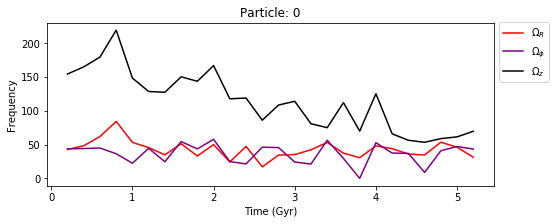

In [12]:
for i in range(1):
    df_r=pd.read_csv(freq_path+filenames[i])
    fig1=plt.figure(figsize=(8,3))
    ax=fig1.add_subplot(111)
    #ax.plot(df_r.t,df_r.omega_r,c='red',label="$\omega$$_R$")
    #ax.plot(df_r.t,df_r.omega_phi,c='purple',label="$\omega$$_$\phi$$")
    #ax.plot(df_r.t,df_r.omega_z,c="black",label="v$\omega$R")
    #ax.text(4,200,"Particle: "+str(i))
    ax.set_title("Particle: "+str(i))
    ax.plot(df_r.t,abs(df_r.omega_r),c='red',label="$\Omega$$_R$")
    ax.plot(df_r.t,abs(df_r.omega_phi),c='purple',label="$\Omega$$_\phi$")
    ax.plot(df_r.t,abs(df_r.omega_z),c="black",label="$\Omega$$_z$")
    ax.legend(bbox_to_anchor=(1.00,0.82), loc='center left',markerscale=9)
    ax.set_xlabel("Time (Gyr)")
    #ax.set_xlim(0,2)
    ax.set_ylabel(r"Frequency")
    plotname="particle_"+str(i)+"_freqs_over_time_200Myr_range_without_pp_abs_cycl.jpg"
    fig1.savefig(plotpath+plotname,bbox_inches="tight",dpi=300)
    print("Plot generated and saved to file: ",plotname)
    #plt.show()